# Practical Application 2: What drives the price of a car?

# Overview
Provide you client analytical insights as to what drives the price of used cars. This will be accompished by using a dataset of used car prices and features. Price will be the target variable while the remainder features of the data will be used in various modeling techniques to determine which features increase prices and which do not. This will be provided to the client in a final presentation with actionable insights for the owner of the used car business.

## Business Understanding: CRISP-DM Step 1

As a small business owner, maintaining profitability can be a constant challenge. The market place is a dynamic and competitive environment that is constantly changing. Any advantage an owner can make (or find) could translate into increased profits.

In effort to support the client's requirement of understanding which auto characteristics drive used car prices, the following analysis undertakes modeling efforts to determine which auto features the client should look for when pricing autos.

## Data Understanding: CRISP-DM Step 2

The dataset used to undertake this analysis was publicly available consisting of a large sample of over 425K auto sales. In total the data contains eighteen features, one of which is an ID. Four features are integers (two as float) and fourteen character features. Features found in the dataset include many key descriptive attributes about autos. Many of the descriptive features are readily available and not subjective in nature, such as cylinders, odometer and year. Other features are more subjective in nature such as condition. Lastly, some of the features may not provide any insights for the client, including VIN, region and state.
More details about the data itself will be discovered through the data preparation steps that follow.

In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from statsmodels.tsa import arima_process
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [151]:
data = pd.read_csv('/Users/benjaminbond/vehicles.csv')

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [288]:
data.tail()

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
303063,7315913588,28000,1955.0,chevrolet,belair,excellent,8 cylinders,gas,0.0,clean,manual,rwd,sedan,black,oh
4535,7313586566,10500,1978.0,chevrolet,c10 stepside,good,8 cylinders,gas,0.0,clean,other,rwd,truck,custom,al
363713,7316661061,30243,2017.0,ford,f-150 xlt automatic,NaN,NaN,gas,0.0,clean,automatic,rwd,pickup,grey,tx
38189,7311024045,11495,2017.0,hyundai,sonata 2.4l,excellent,4 cylinders,gas,0.0,clean,automatic,NaN,other,NaN,ca
56442,7315184211,22900,2016.0,mazda,cx-9,excellent,4 cylinders,gas,0.0,clean,automatic,fwd,wagon,white,ca


The raw dataset contains: 426,880 rows. 

Visually reviewing the data I can see that the target variable (price) contains zeros. For purposes of this analysis the price of a car should not be $0. since we will be predicting the price of a car having $0 values in the data will throw off the analysis. 

These rows need to be investigated and removed.

In [154]:
# Count the number of rows where price = 0

zero_price_count = (data['price'] == 0).sum()

print("Number of rows with price = 0:", zero_price_count)

Number of rows with price = 0: 32895


In [289]:
#s Remove rows where price = 0

data = data[data['price'] != 0]

print("Data after dropping rows with price = 0:")
print(data.head())

Data after dropping rows with price = 0:
                id  price    year manufacturer        model  condition  \
17065   7307045212   4000  1950.0        dodge          NaN       fair   
81085   7313917230   6999  1973.0        dodge  power wagon       fair   
280733  7313758981   7500  1960.0          NaN      Rambler        NaN   
394897  7306671635   1800  1985.0    chevrolet    k5 blazer       good   
102503  7314078688   7500  1956.0          NaN     corvette  excellent   

          cylinders fuel   odometer title_status transmission drive  \
17065         other  gas  1000000.0        clean       manual   rwd   
81085   8 cylinders  gas  1000000.0        clean    automatic   4wd   
280733          NaN  gas  1000000.0        clean    automatic   NaN   
394897  8 cylinders  gas  1000000.0        clean    automatic   4wd   
102503        other  gas  1000000.0   parts only        other   rwd   

               type paint_color state  
17065         truck         NaN    az  
81085  

After running the previous set there are now 393,985 rows. This is not the final row count, additional data proofing must be conducted.

Bad and missing data must now be identified and handled.

The plot below is a visual representation of missing data by feature.

<Axes: title={'center': 'Missing data'}>

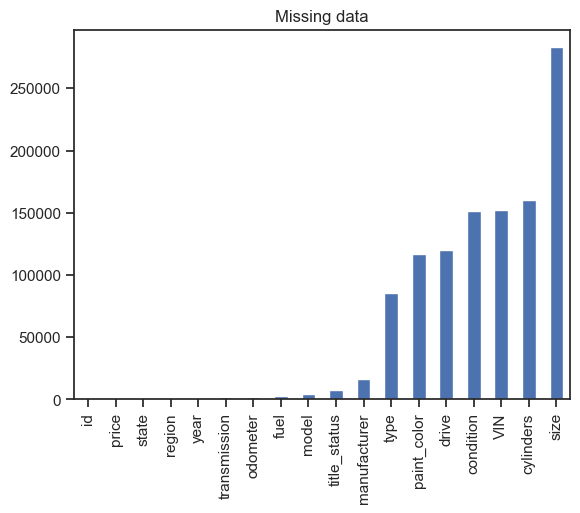

In [157]:
data.isnull().sum().sort_values().plot(kind='bar',title='Missing data')

We can see this dataset contains a large amount of missing data.

What needs to be determined is if we omit the missing data or run transformations against numeric features such as imputations.

One way to determine if imputation is an option is to visually review the data. Below is the output of a pairplot run against a sample set of three integer features.

/Users/benjaminbond/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


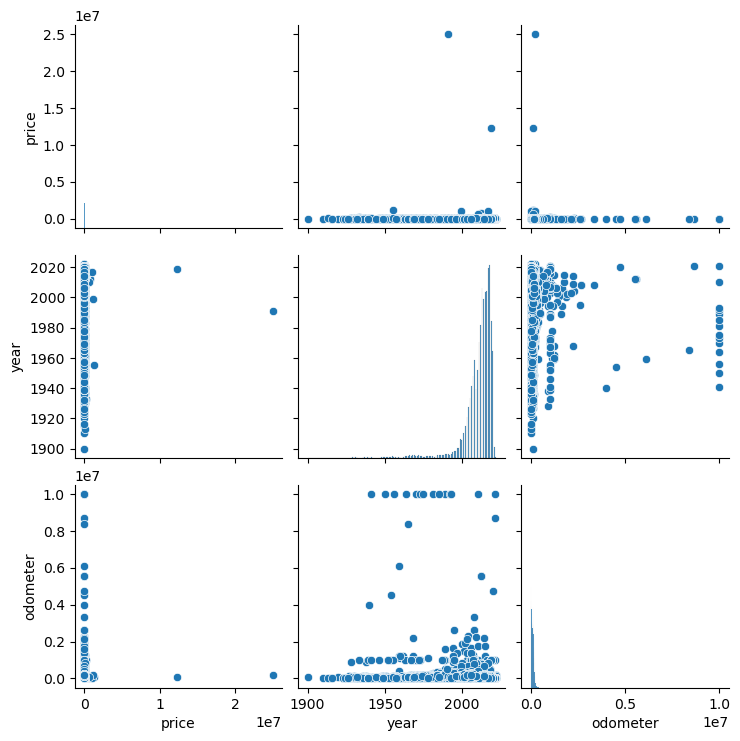

In [14]:
# sample down the dataset to 50,000 rows
data_sample = data.sample(n=50000, random_state=42)

# Run a pairplot dropping the ID feature
sns.pairplot(data=data_sample, vars=['price', 'year', 'odometer'])
plt.show()

The output of the pairplot indicates there are groupings of correlations among observations but that outliers are masking any differentiation between features of 'price', 'year' and 'odometer'.

Further investigation into the 'price' feature is conducted below beginning with sorting the data on that column to see the largest prices in the data.

## Data Preparation: CRISP-DM Step 3

Data preparation for this analysis begins with the target feature. Below is a sort descending on 'price' looking for large values in this feature.

In [291]:
# Order by price descending to visually observe how large the largest sales price are
data = data.sort_values(by='price', ascending=False)

# Note: the query flow has since been rerun and the high value prices have been removed in the output below.

In [293]:
data.head()

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
414119,7306722227,100000,2018.0,dodge,NaN,NaN,8 cylinders,other,959.0,clean,automatic,fwd,other,NaN,wv
68063,7308548387,100000,2021.0,NaN,Camaro mustang,NaN,NaN,gas,1000.0,clean,automatic,NaN,NaN,NaN,ca
63183,7316071178,100000,1957.0,chevrolet,belair 1957,NaN,NaN,gas,16100.0,clean,automatic,NaN,NaN,NaN,ca
146743,7303217228,100000,2018.0,dodge,NaN,NaN,8 cylinders,other,959.0,clean,automatic,fwd,other,NaN,il
4799,7302282925,100000,2018.0,dodge,NaN,NaN,8 cylinders,other,959.0,clean,automatic,fwd,other,NaN,al


In [161]:
# Count the number of rows where the price is over 100K
count_price_over_100000 = (data['price'] > 100000).sum()

print("Number of rows with price over 100,000:", count_price_over_100000)


Number of rows with price over 100,000: 655


In [162]:
# Calculate the average price of autos in the dataset
average_price = data['price'].mean()

print("Average price:", average_price)


Average price: 81477.62804929122


Based on the investigation I ran against the 'price' feature, there are 655 rows of data with auto prices over $100,000 increasing the average price of an auto in the dataset to $81,478.

This average price of a car is unrealistically high for a used car dealer.

We need to decide what to do with the bad data. In this case because only 655 rows are impacted, I have chosen to remove rows with a 'price' over $100,000.

Below is the query used to remove rows of data where the 'price' value is greater than 100K.

In [163]:
# Drop rows where the 'price' feature is greater than 100,000
data = data[data['price'] <= 100000]

# Display the first few rows of the filtered DataFrame
print("First few rows after dropping rows with price > 100,000:")
print(data.head())


First few rows after dropping rows with price > 100,000:
                id        region   price    year manufacturer model condition  \
45029   7309635192  palm springs  100000  2020.0          NaN   All       NaN   
262592  7301950921    las cruces  100000  2018.0        dodge   NaN       NaN   
330246  7314300775     lancaster  100000  1970.0          gmc   NaN      good   
262556  7303203378    las cruces  100000  2018.0        dodge   NaN       NaN   
414119  7306722227    charleston  100000  2018.0        dodge   NaN       NaN   

          cylinders   fuel  odometer title_status transmission  \
45029           NaN  other   80000.0        clean        other   
262592  8 cylinders  other     959.0        clean    automatic   
330246          NaN    gas   70000.0        clean       manual   
262556  8 cylinders  other     959.0        clean    automatic   
414119  8 cylinders  other     959.0        clean    automatic   

                      VIN drive     size   type paint_color

In [166]:
# Vaidation of the number of rows where the price is over 100K
count_price_over_100000 = (data['price'] > 100000).sum()

print("Number of rows with price over 100,000:", count_price_over_100000)


Number of rows with price over 100,000: 0


In [165]:
# Calculate the average price, which is too high for used cars
average_price = data['price'].mean()

print("Average price:", average_price)

Average price: 18717.94980296443


After removing the 'price' outliers we validate the average price of an auto in the dataset. 

The average price is now down to $18,718. 

This seems a far more reasonable price for used car. 

After cleaning up the 'price' feature in the dataset I again ran a sample of rows as a pairplot. 

As seen in the output below, correlation seperation is better but outliers still remain in the 'odometer' feature.

/Users/benjaminbond/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


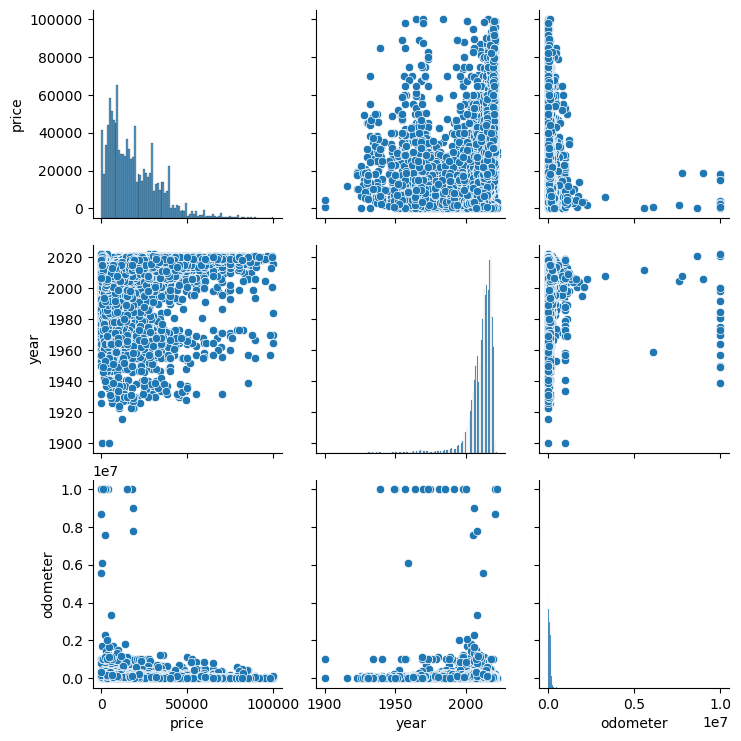

In [26]:
# sample down the dataset to 50,000 rows
data_sample = data.sample(n=50000, random_state=42)

# Run a pairplot dropping the ID feature
sns.pairplot(data=data_sample, vars=['price', 'year', 'odometer'])
plt.show()

Like the 'price' feature, I will start by visually reviewing the raw 'odometer' values in the dataset. As we can see below, there are a number of autos with odometer values of 1,000,000.

This is a very high value for a car to be driven.

In [167]:
# Order by odometer descending to visually ovserve how large the largest sales price are
data = data.sort_values(by='odometer', ascending=False)

In [168]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
262338,7313707752,las cruces,4800,1949.0,ford,f1,good,8 cylinders,gas,10000000.0,missing,manual,NaN,rwd,full-size,pickup,blue,nm
340694,7307996177,williamsport,10000,2006.0,lexus,rx 330,NaN,NaN,gas,10000000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,pa
346469,7313602958,florence,1700,1973.0,NaN,1973 nova,NaN,NaN,other,10000000.0,clean,other,NaN,NaN,NaN,NaN,NaN,sc
191629,7302142167,western massachusetts,7500,1970.0,chevrolet,chevelle,fair,8 cylinders,gas,10000000.0,parts only,automatic,NaN,rwd,full-size,coupe,red,ma
108102,7316668762,sarasota-bradenton,450,2000.0,ford,f-150,NaN,NaN,gas,10000000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,fl


In [169]:
# Count the number of rows where the price is over 100K
count_odometer_over_1000000 = (data['odometer'] > 1000000).sum()

print("Number of rows with odometer over 1,000,000:", count_odometer_over_1000000)

Number of rows with odometer over 1,000,000: 460


There are 460 rows of data where the odometer value is over 1M. 

Again, because there are only a few hundred of these rows as outliers, they will be dropped.

In [170]:
# Drop rows where the 'odometer' feature is greater than 1M
data = data[data['odometer'] <= 1000000]

# Display the first few rows of the filtered DataFrame
print("First few rows after dropping rows with odometer > 1,000,000:")
print(data.head())


First few rows after dropping rows with odometer > 1,000,000:
                id                   region  price    year manufacturer  \
17065   7307045212                     yuma   4000  1950.0        dodge   
81085   7313917230                   pueblo   6999  1973.0        dodge   
280733  7313758981                 syracuse   7500  1960.0          NaN   
394897  7306671635  norfolk / hampton roads   1800  1985.0    chevrolet   
102503  7314078688                    ocala   7500  1956.0          NaN   

              model  condition    cylinders fuel   odometer title_status  \
17065           NaN       fair        other  gas  1000000.0        clean   
81085   power wagon       fair  8 cylinders  gas  1000000.0        clean   
280733      Rambler        NaN          NaN  gas  1000000.0        clean   
394897    k5 blazer       good  8 cylinders  gas  1000000.0        clean   
102503     corvette  excellent        other  gas  1000000.0   parts only   

       transmission  VIN drive

In [171]:
# Validation of the number of rows where the odometer is over 1M
count_odometer_over_1000000 = (data['odometer'] > 1000000).sum()

print("Number of rows with odometer over 1,000,000:", count_odometer_over_1000000)


Number of rows with odometer over 1,000,000: 0


Running a third pairplot returns even better correlation separation. This indicates many outliers have been addressed in these features.

/Users/benjaminbond/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


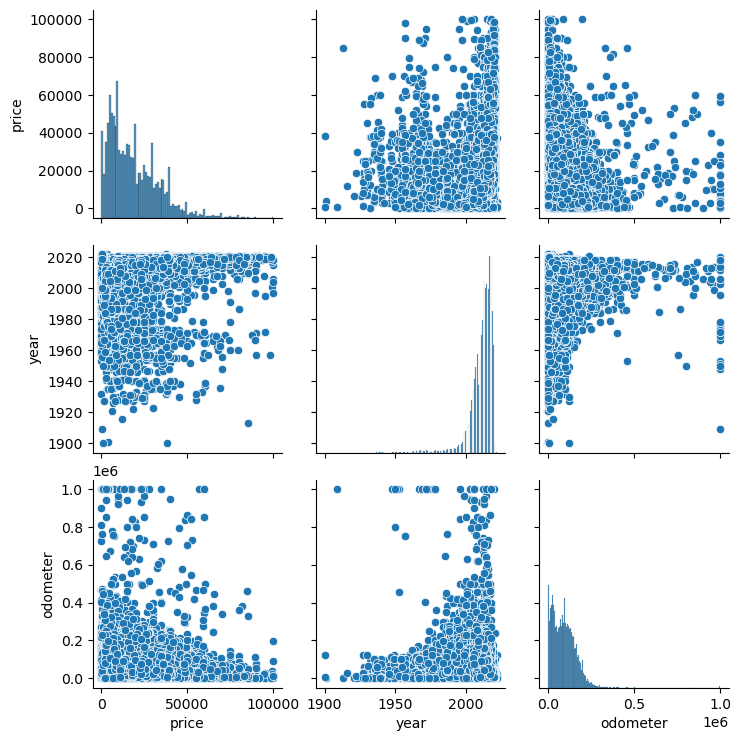

In [32]:
# Sample down the dataset to 50,000 rows
data_sample = data.sample(n=50000, random_state=42)

# Run a pairplot dropping the ID feature
sns.pairplot(data=data_sample, vars=['price', 'year', 'odometer'])
plt.show()

Next step is to identify missing data by individual feature.

In [172]:
#Count missing values in each feature

nan_counts = data.isnull().sum()

print("NaN counts in each individual feature:")
print(nan_counts)

NaN counts in each individual feature:
id                   0
region               0
price                0
year              1109
manufacturer     15769
model             4518
condition       150011
cylinders       158748
fuel              2321
odometer             0
title_status      7463
transmission      1513
VIN             150299
drive           119217
size            280386
type             85057
paint_color     115642
state                0
dtype: int64


<Axes: title={'center': 'Missing data'}>

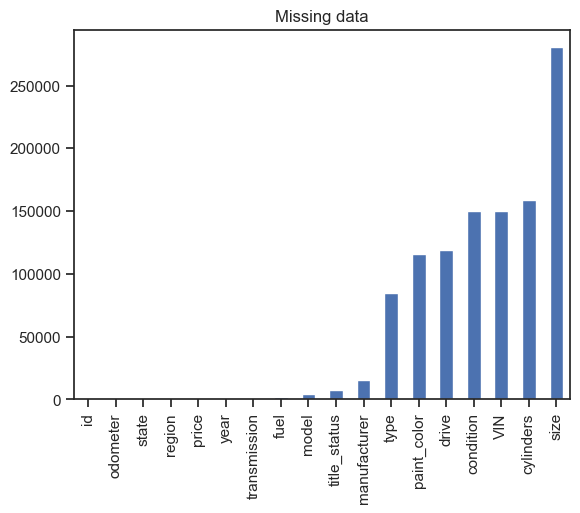

In [173]:
#Visual representation of missing data by feature

data.isnull().sum().sort_values().plot(kind='bar',title='Missing data')

Reviewing the plot above, we see that the 'size' feature has the largest number of missing values.

One additional step will help in making determinations as to how best address missing data. In the next step the code returns a unique count of variables contained in each feature.

In [174]:
#Return distinct counts of data in each feature
feature = ['region','year','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color','state']  # Replace 'your_feature_name_here' with the actual feature name

distinct_count = data[feature].nunique()

print("Distinct count of data in feature '{}': {}".format(feature, distinct_count))


Distinct count of data in feature '['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']': region            404
year              112
manufacturer       42
model           27904
condition           6
cylinders           8
fuel                5
title_status        6
transmission        3
drive               3
size                4
type               13
paint_color        12
state              51
dtype: int64


Reviewing the output by feature we see a large number of unique values contained in the 'model' feature. This is expected because this field appears to be an open text field allowing for any input.

Interestingly there are 112 unique years that appear in the dataset. This requires more investigation.

The following code returns a sorted array of data contained in the 'year' feature.

In [175]:
# Display unique year values
unique_years = data['year'].unique()
unique_years_descending = sorted(unique_years, reverse=True)

print("unique year values (descending):")
print(unique_years_descending)


unique year values (descending):
[2022.0, 2021.0, 2020.0, 2019.0, 2018.0, 2017.0, 2016.0, 2015.0, 2014.0, 2013.0, 2012.0, 2011.0, 2010.0, 2009.0, 2008.0, 2007.0, 2006.0, 2005.0, 2004.0, 2003.0, 2002.0, 2001.0, 2000.0, 1999.0, 1998.0, 1997.0, 1996.0, 1995.0, 1994.0, 1993.0, 1992.0, 1991.0, 1990.0, 1989.0, 1988.0, 1987.0, 1986.0, 1985.0, 1984.0, nan, 1983.0, 1982.0, 1981.0, 1980.0, 1979.0, 1978.0, 1977.0, 1976.0, 1975.0, 1974.0, 1973.0, 1972.0, 1971.0, 1970.0, 1969.0, 1968.0, 1967.0, 1966.0, 1965.0, 1964.0, 1963.0, 1962.0, 1961.0, 1960.0, 1959.0, 1958.0, 1957.0, 1956.0, 1955.0, 1954.0, 1953.0, 1952.0, 1951.0, 1950.0, 1949.0, 1948.0, 1947.0, 1946.0, 1945.0, 1944.0, 1943.0, 1942.0, 1941.0, 1940.0, 1939.0, 1938.0, 1937.0, 1936.0, 1935.0, 1934.0, 1933.0, 1932.0, 1931.0, 1930.0, 1929.0, 1928.0, 1927.0, 1926.0, 1925.0, 1924.0, 1923.0, 1922.0, 1921.0, 1920.0, 1918.0, 1916.0, 1915.0, 1913.0, 1910.0, 1909.0, 1905.0, 1901.0, 1900.0]


Regarding the year feature, we can see that nearly all years between 1900 and 2022 are present, which is explainable. We also see there is a unique missing value returned.

As a data analyst, there are times when decisions need to be made while preparing the data for analysis. One such decision is required at this point of the process; what should be done with the missing data? In this dataset there are nearly 210,000 rows of missing data across all features. 

There are several approaches to handling missing data. Imputations using several various methods (mean, medium, mode) work for data that are integers, which all features are not in our dataset. Another method is domain knowledge, this method leverages subject matter experts to provide input to determine the worth of the missing data. This will not be the case for this study. A third and quickest approach is to remove missing data.

For this exercise I recommend removing the missing data methodologically. This will de done in two steps: first, drop features that will not be used in the modeling step at all. Those features are 'size' (do to the large amount of missing data), 'VIN' (which is a unique identifier) and 'region'. The second step is to use the dropna function against the remaining features.

In [186]:
# Step 1: drop 'size' and 'VIN' features from the 'data' dataset
data = data.drop(columns=['size', 'VIN', 'region'])

In [187]:
# Step 2: drop missing data
data_Clean = data.dropna()

# Display
print("First few rows of 'data_Clean':")
print(data_NoMissing.head())


First few rows of 'data_Clean':
                id                    region  price    year manufacturer  \
403465  7312225336  kennewick-pasco-richland  22995  2003.0          ram   
403019  7314114370  kennewick-pasco-richland  22500  2003.0          ram   
402675  7315454657  kennewick-pasco-richland  22500  2003.0          ram   
190505  7311497954     western massachusetts  11999  2009.0    chevrolet   
402606  7315793385  kennewick-pasco-richland  22500  2003.0          ram   

        model condition    cylinders    fuel  odometer title_status  \
403465   3500  like new  6 cylinders  diesel  999999.0        clean   
403019   3500  like new  6 cylinders  diesel  999999.0        clean   
402675   3500  like new  6 cylinders  diesel  999999.0        clean   
190505  tahoe      good  8 cylinders     gas  999999.0        clean   
402606   3500  like new  6 cylinders  diesel  999999.0        clean   

       transmission                VIN drive       size    type paint_color  \
40346

In [188]:
# Count rows in each dataset
count_data = data.shape[0]
count_clean = data_Clean.shape[0]

print("Number of rows in data:", count_data)
print("Number of rows in data_clean:", count_clean)

Number of rows in data: 390587
Number of rows in data_clean: 111421


The remaining dataset after dropping missing values consists of 111,421 rows. This is a substantial drop in row count, but should provide enough variability and stability in the data to return usable model outputs.

The following code is used to remove the decimal in the year data.

In [190]:
# Convert year to integers without decimals
data_Clean['year'] = data_Clean['year'].astype(int)

unique_years = data_Clean['year'].unique()
unique_years_descending = sorted(unique_years, reverse=True)

print("Unique values in the 'year' feature (without decimals):")
print(unique_years_descending)

Unique values in the 'year' feature (without decimals):
[2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949, 1948, 1947, 1946, 1944, 1942, 1941, 1940, 1939, 1938, 1937, 1936, 1935, 1934, 1933, 1932, 1931, 1930, 1929, 1928, 1927, 1926, 1925, 1924, 1923, 1918, 1913, 1905, 1900]


/var/folders/wh/n3cd2y512zb7kz6vl0n6rh180000gn/T/ipykernel_1663/1062248005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Clean['year'] = data_Clean['year'].astype(int)


One last review of the data showed that there were duplicates in the data. Examples of duplicate data include IDs 7314114370 and 7315454657. All of the data in the features are the same with the exception of the IDs.

In order to clean these duplicate data, the first step is to drop the non-duplicate feature the second step is to run the .drop_duplicates() function.

In [192]:
# Remove ID feature
data_Clean.drop(columns=['id'], inplace=True)

# Run deduplication step
data_Clean_no_dupes = data_Clean.drop_duplicates()

# Reapply the 'id' feature
data_Clean_no_dupes.reset_index(drop=True, inplace=True)
data_Clean_no_dupes.insert(0, 'id', range(1, len(data_Clean_no_dupes) + 1))

# Display the updated dataset
print(data_Clean_no_dupes.head())

   id  price  year manufacturer         model condition    cylinders fuel  \
0   1   6999  1973        dodge   power wagon      fair  8 cylinders  gas   
1   2   1800  1985    chevrolet     k5 blazer      good  8 cylinders  gas   
2   3   2000  2004    chevrolet     silverado      good  4 cylinders  gas   
3   4  12000  1949         ford           f-1      fair  6 cylinders  gas   
4   5  35000  1978       toyota  land cruiser      good  8 cylinders  gas   

    odometer title_status transmission drive    type paint_color state  
0  1000000.0        clean    automatic   4wd  pickup        grey    co  
1  1000000.0        clean    automatic   4wd     SUV       white    va  
2  1000000.0        clean    automatic   rwd  pickup        blue    tx  
3  1000000.0        clean       manual   rwd  pickup        blue    co  
4  1000000.0        clean       manual   4wd     SUV         red    al  


/var/folders/wh/n3cd2y512zb7kz6vl0n6rh180000gn/T/ipykernel_1663/2796913594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Clean.drop(columns=['id'], inplace=True)


The one hot coding method was used to take categorical features in the dataset and transform them into interval level data. This is done so additional features can be used in regression models. 

In [197]:
# Select categorical features to create dummy variables
categorical_features = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state']

dummy_df = pd.get_dummies(data_Clean_no_dupes[categorical_features], drop_first=True, dtype=int)
data_with_dummies = pd.concat([data_Clean_no_dupes, dummy_df], axis=1)
data_with_dummies.drop(columns=categorical_features, inplace=True)

print(data_with_dummies.head())



   id  price  year   odometer  manufacturer_alfa-romeo  \
0   1   6999  1973  1000000.0                        0   
1   2   1800  1985  1000000.0                        0   
2   3   2000  2004  1000000.0                        0   
3   4  12000  1949  1000000.0                        0   
4   5  35000  1978  1000000.0                        0   

   manufacturer_aston-martin  manufacturer_audi  manufacturer_bmw  \
0                          0                  0                 0   
1                          0                  0                 0   
2                          0                  0                 0   
3                          0                  0                 0   
4                          0                  0                 0   

   manufacturer_buick  manufacturer_cadillac  ...  state_sd  state_tn  \
0                   0                      0  ...         0         0   
1                   0                      0  ...         0         0   
2                

This step bins the feature 'years' into decades in attempts to determine if groups of years influences price.

In [199]:
# Define bins
bin_edges = [1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]

# Create bins for the 'year' feature
data_with_dummies['year_bins'] = pd.cut(data_with_dummies['year'], bins=bin_edges)
year_bins_dummies = pd.get_dummies(data_with_dummies['year_bins'], prefix='year_bin', drop_first=True, dtype=int)
data_with_bins = pd.concat([data_with_dummies, year_bins_dummies], axis=1)
data_with_bins.drop(columns=['year_bins'], inplace=True)

print(data_with_bins.head())


   id  price  year   odometer  manufacturer_alfa-romeo  \
0   1   6999  1973  1000000.0                        0   
1   2   1800  1985  1000000.0                        0   
2   3   2000  2004  1000000.0                        0   
3   4  12000  1949  1000000.0                        0   
4   5  35000  1978  1000000.0                        0   

   manufacturer_aston-martin  manufacturer_audi  manufacturer_bmw  \
0                          0                  0                 0   
1                          0                  0                 0   
2                          0                  0                 0   
3                          0                  0                 0   
4                          0                  0                 0   

   manufacturer_buick  manufacturer_cadillac  ...  state_wa  state_wi  \
0                   0                      0  ...         0         0   
1                   0                      0  ...         0         0   
2                

In [200]:
# Renaming paint_color in order to suppress in models
data_with_bins.rename(columns={'paint_color': 'paint'}, inplace=True)

print(data_with_bins.head())


   id  price  year   odometer  manufacturer_alfa-romeo  \
0   1   6999  1973  1000000.0                        0   
1   2   1800  1985  1000000.0                        0   
2   3   2000  2004  1000000.0                        0   
3   4  12000  1949  1000000.0                        0   
4   5  35000  1978  1000000.0                        0   

   manufacturer_aston-martin  manufacturer_audi  manufacturer_bmw  \
0                          0                  0                 0   
1                          0                  0                 0   
2                          0                  0                 0   
3                          0                  0                 0   
4                          0                  0                 0   

   manufacturer_buick  manufacturer_cadillac  ...  state_wa  state_wi  \
0                   0                      0  ...         0         0   
1                   0                      0  ...         0         0   
2                

## Modeling: CRISP-DM Step 4

With the data preparation step primarily done, the next step is modeling. In order to provide a usable recommendation for our client, the modeling process must accurately predict 'price'. Prediction can be an output of regression models. Several regression approaches will be progressively used through this exercise. Each of the model outputs will be evaluated using mean squared error as the primary metric for measure.

The first model run was an Ordinarily Least Squares (OLS).

In [201]:
# Select features
columns_to_exclude = ['manufacturer', 'state', 'model']

# Filter features
dummy_columns_to_drop = [col for col in data_with_bins.columns if any(col.startswith(feature) for feature in columns_to_exclude)]
X = data_with_bins.drop(columns=['price'] + dummy_columns_to_drop)
y = data_with_bins['price']
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     2985.
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:02:42   Log-Likelihood:            -8.9794e+05
No. Observations:               87066   AIC:                         1.796e+06
Df Residuals:                   87008   BIC:                         1.797e+06
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -9

The OLS summary indicates a Rsquared of 0.662. As the first model run we will compare as additional models are generated. Also in the summary output are coefficient metrics. This is helpful to review so we can see how much impact a features data had in the model output. For example we see that 'condition_new' has more explanatory power when predicting 'price' than does  'condition_like new'.

Below is the plot displaying the relationship between prediction and actual price. The model preforms well until the mid-30,000 price level, after that the model prediction power degrades quickly.

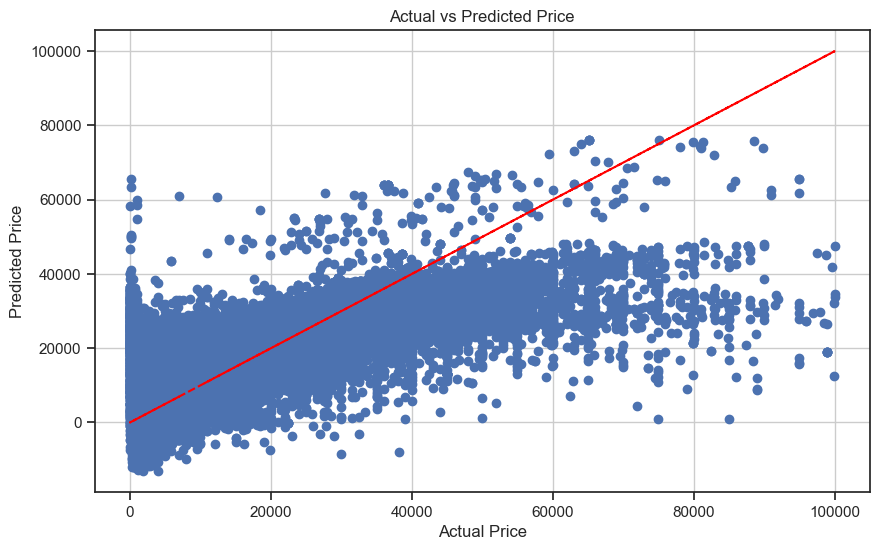

In [202]:
predicted_values = model.predict(X)

# Plot the predicted against actual
plt.figure(figsize=(10, 6))
plt.scatter(y, predicted_values)
plt.plot(y, y, color='red', linestyle='--')
plt.title('Actual vs Predicted Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()


One data point that caught my eye is the color orange. That color specifically has a high explanatory power. The next few steps are further investigation as to why the color orange is so prominent in the model.

In [203]:
# Filter features for analysis
filtered_data = data_Clean_no_dupes[['odometer', 'price', 'paint_color', 'manufacturer', 'year']]

# Filter rows for 'orange'
orange_paint_rows = filtered_data[data_Clean_no_dupes['paint_color'] == 'orange']
orange_paint_rows_sorted = orange_paint_rows.sort_values(by='price', ascending=False)

print(orange_paint_rows)


       odometer  price paint_color manufacturer  year
59     930128.0   5475      orange        dodge  2008
69     777777.0   1500      orange         jeep  1977
230    362000.0   6500      orange         ford  2006
752    293000.0   2999      orange        honda  2003
852    287000.0  11000      orange          gmc  2001
...         ...    ...         ...          ...   ...
86723      15.0    149      orange          kia  2021
86742      10.0    300      orange    chevrolet  1970
86769       4.0  65000      orange    chevrolet  1969
87032       0.0  30000      orange    chevrolet  1955
87044       0.0  49995      orange    chevrolet  1975

[527 rows x 5 columns]


In [204]:
orange_paint_rows_sorted.head()

,odometer,price,paint_color,manufacturer,year
47864,100612.0,75000,orange,porsche,1971
86022,640.0,75000,orange,porsche,1971
85436,2443.0,74995,orange,chevrolet,2019
80875,20000.0,69999,orange,chevrolet,2015
70101,50000.0,69975,orange,dodge,1971


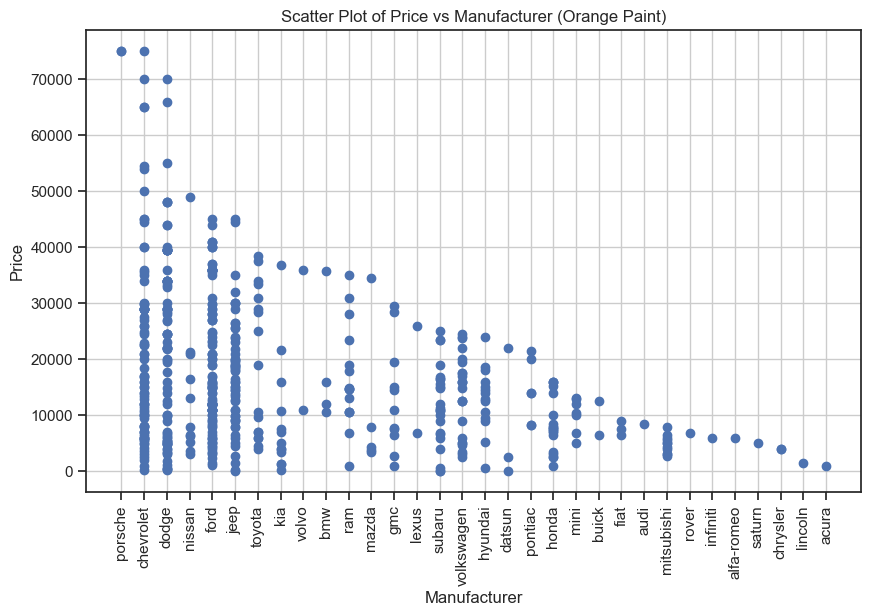

In [205]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(orange_paint_rows_sorted['manufacturer'], orange_paint_rows_sorted['price'])
plt.title('Scatter Plot of Price vs Manufacturer (Orange Paint)')
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


The output of the plot shows that several orange autos have high resale prices in proportion to the total number of orange autos in the dataset.

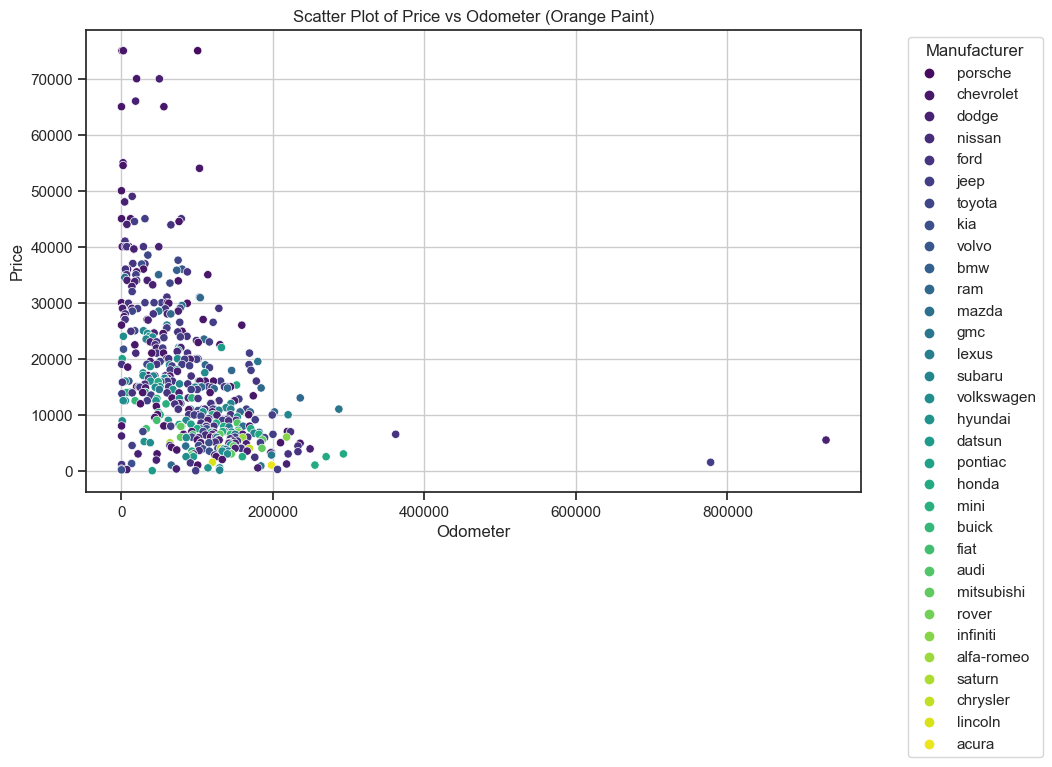

In [206]:
# Plot style
sns.set(style="ticks")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='odometer', y='price', hue='manufacturer', data=orange_paint_rows_sorted, palette='viridis')
plt.title('Scatter Plot of Price vs Odometer (Orange Paint)')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.grid(True)
plt.legend(title='Manufacturer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


The above plot shows the color orange including manufacturer as hue. This clearly shows a few outliers in the plot and explains why that specific color is some influential in the model.

### Multiple linear regressions

In [295]:
# Linear regression using only two features from the No Dupes dataset

X = data_Clean_no_dupes[['year', 'odometer']] 
y = data_Clean_no_dupes['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
y_pred = linear_reg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)


Mean Squared Error (MSE): 113847873.40897541
R^2 Score: 0.29871276755696397


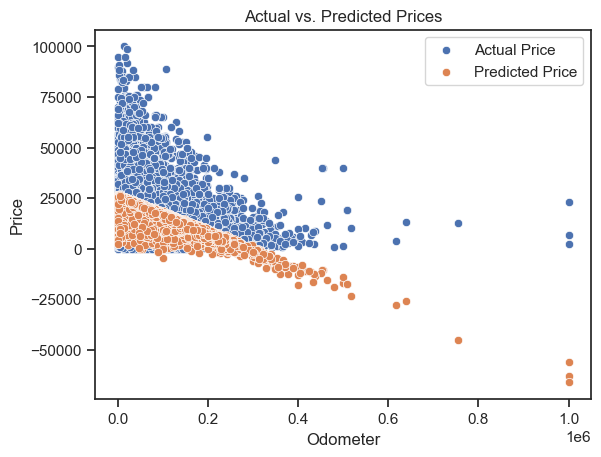

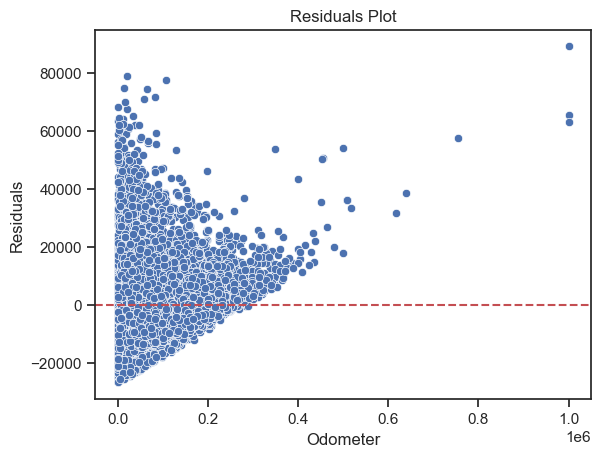

Mean Squared Error (MSE): 113847873.40897541
R^2 Score: 0.29871276755696397


In [296]:
# Create a DataFrame with test data and predicted prices
test_results = X_test.copy()
test_results['price'] = y_test
test_results['predicted_price'] = y_pred

# Actual vs. predicted prices
sns.scatterplot(data=test_results, x='odometer', y='price', label='Actual Price')
sns.scatterplot(data=test_results, x='odometer', y='predicted_price', label='Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.legend()
plt.show()

# Residuals
test_results['residuals'] = test_results['price'] - test_results['predicted_price']
sns.scatterplot(data=test_results, x='odometer', y='residuals')
plt.title('Residuals Plot')
plt.xlabel('Odometer')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)


The output plots from the above regression clearly show the model is undervaluing auto prices particularly at values above $25,000 based on the linear relationship of the odometer feature. The residuals plot displaying the amount of variance between predicted and actual price clearly display a pattern (or lack of homoscedasticity) and a lack of observed points congregation around zero. 

In [207]:
# Linear regression using binned dataset
X = data_with_bins.drop(columns=['price'])
y = data_with_bins['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 43352418.350327626
R-squared: 0.732955069126332


Comparing the two linear regression results indicate the second model performed more than twice as well as the first model. The MSE of the bin model is a third of the year and odometer model and the Rsquare is more than double that of the first model.

Below is a visualization of the model. 

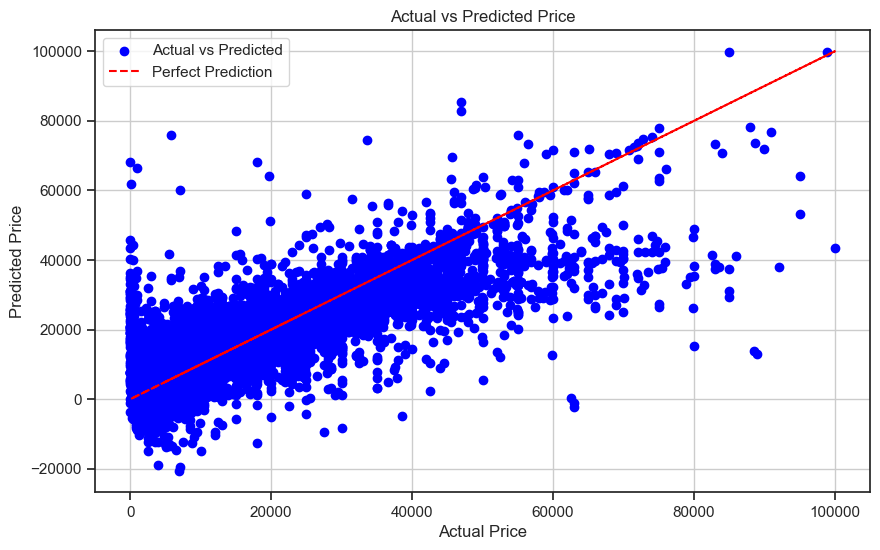

In [208]:
# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.show()


The scatter plot above shows a decent fit of prediction by the model.

Displaying coefficients including the feature 'model' was too long given the grading rubric. Due to the huge number of distinct models the complexity to operationalize a tool using 'model' as an input (a consistent way for the client to plug features into a macro function supported by excel, for example) would be too high. There is no need to include a display of 'model' for purposes of this exercise.

In [ ]:
# Displaying the coefficients of the multiple linear regression model
#print("Coefficients:")
#for feature, coefficient in zip(X.columns, model.coef_):
#    print(f"{feature}: {coefficient}")


The model below is designed to be a simplification of the multiple linear regression perviously run by omitting 'model' and 'state' features.

Although this third linear regression model outperformed the first model by nearly double when comparing MSE and Rsquare, it did not perform as well as the binned model using the same comparison metrics.

From an ease of operationalizing perspective the more simplified model omitting features 'model' and 'state' would definately be easier to maintain. This should be a consideration when the final evaluation is completed.

In [210]:
# Define features
X = data_with_bins.drop(columns=['price'])
X = X.loc[:, ~X.columns.str.contains('model|state')]
y = data_with_bins['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 50711624.41865265
R-squared: 0.687623372520159


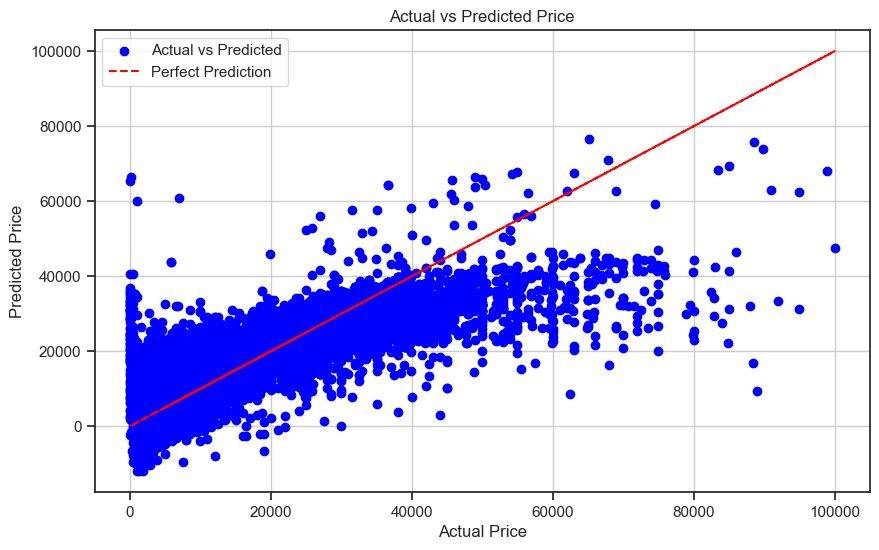

In [211]:
# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.show()


We can see that prediction fit of the model is better with lower priced autos compared to higher priced autos.

In [212]:
# Display of each model coefficient
print("Coefficients:")
for feature, coefficient in zip(X.columns, model.coef_):
    print(f"{feature}: {coefficient}")


Coefficients:
id: 0.17334590018196533
year: 513.1074049821093
odometer: 0.002616343645058805
manufacturer_alfa-romeo: 3150.1443908679657
manufacturer_aston-martin: 34182.90158275736
manufacturer_audi: -1312.4794216206337
manufacturer_bmw: -2654.9460503956034
manufacturer_buick: -3054.878367594696
manufacturer_cadillac: -2083.585278283632
manufacturer_chevrolet: -2644.4397670891703
manufacturer_chrysler: -4546.164494132678
manufacturer_datsun: 2409.223800795582
manufacturer_dodge: -4400.823193401244
manufacturer_ferrari: 46806.52457732677
manufacturer_fiat: -9266.505906786702
manufacturer_ford: -3237.070460936324
manufacturer_gmc: -1974.0688424219534
manufacturer_harley-davidson: -4178.121550410337
manufacturer_honda: -484.98336762839244
manufacturer_hyundai: -4034.7155735094616
manufacturer_infiniti: -2339.148577010688
manufacturer_jaguar: -1791.960463890574
manufacturer_jeep: -1634.642775643214
manufacturer_kia: -4795.0599395691925
manufacturer_land rover: 2211.951583831571
manufactur

Reviewing the coefficient output above, we see that operationalizing this model would be much more feasible because there are fewer data variations in each of the features.

In [260]:
# Note - creating a backup dataset (not used for analysis)
data_Clean_no_dupes_BU = data_Clean_no_dupes.copy()

In [300]:
#Note: a few datasets have been created to this point. Managing row counts.
# Count rows in each dataset
count_data = data.shape[0]
count_clean = data_Clean.shape[0]
count_no_dupes = data_Clean_no_dupes.shape[0]
count_no_dupes_BU = data_Clean_no_dupes_BU.shape[0]
count_dummies = data_with_dummies.shape[0]
count_bins = data_with_bins.shape[0]
count_below_50k = data_with_bins_below_50k.shape[0]
count_above_50k = data_with_bins_above_50k.shape[0]

print("Number of rows in data:", count_data)
print("Number of rows in data_clean:", count_clean)
print("Number of rows in data_no_dupes:", count_no_dupes)
print("Number of rows in data_no_dupes_BU:", count_no_dupes_BU)
print("Number of rows in data_with_dummies:", count_dummies)
print("Number of rows in data_with_bins:", count_bins)
print("Number of rows in dataset with price <= 50000:", count_below_50k)
print("Number of rows in dataset with price > 50000:", count_above_50k)


Number of rows in data: 390587
Number of rows in data_clean: 111421
Number of rows in data_no_dupes: 87066
Number of rows in data_no_dupes_BU: 87066
Number of rows in data_with_dummies: 87066
Number of rows in data_with_bins: 87066
Number of rows in dataset with price <= 50000: 85741
Number of rows in dataset with price > 50000: 1325


Based on previous regression model's poor performance, I was curious how models would perform if the target variable was broken into two different datasets, auto 'price' above and below $50000.

In [ ]:
# Create two datasets based on price condition
data_with_bins_below_50k = data_with_bins[data_with_bins['price'] <= 50000].copy()
data_with_bins_below_50k['price'] = data_with_bins_below_50k['price'].astype(int)
data_with_bins_below_50k = pd.DataFrame(data_with_bins_below_50k)

data_with_bins_above_50k = data_with_bins[data_with_bins['price'] > 50000].copy()
data_with_bins_above_50k['price'] = data_with_bins_above_50k['price'].astype(int)
data_with_bins_above_50k = pd.DataFrame(data_with_bins_above_50k)

The following multiple linear regression model is being run against the dataset with 'price' below $50,000.

In [233]:
# Define features
X = data_with_bins_below_50k.drop(columns=['price'])
y = data_with_bins_below_50k['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
multiple_reg_model = LinearRegression()
multiple_reg_model.fit(X_train, y_train)
y_pred = multiple_reg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)



Mean Squared Error (MSE): 3844418780143043.0
R^2 Score: -31808880.25067501


Curiosity satisfied; splitting the dataset by price did not work. No need to continue exploring that option since the MSE is much larger then the previous model and the Rsquared is negative.

### Running polynomial features

Having explored many different versions of linear regressions, it is time to begin the process of running polynomial regressions in hopes of discovering nonlinear relationships. 

In [251]:
# Define features
X = data_Clean_no_dupes[['odometer', 'year']]
y = data_Clean_no_dupes['price']


degree = 3
cubic_pipe = Pipeline([
    ('quad_features', PolynomialFeatures(degree=degree)),
    ('quad_model', LinearRegression())
])

cubic_pipe.fit(X, y)
coefficients = cubic_pipe.named_steps['quad_model'].coef_
intercept = cubic_pipe.named_steps['quad_model'].intercept_
cubic_mse = mean_squared_error(y, cubic_pipe.predict(X))

print("Coefficients:", coefficients)
print("Intercept:", intercept)
print("Mean Squared Error:", cubic_mse)


Coefficients: [ 0.00000000e+00  1.98557737e-01 -6.87748206e-03 -4.22101080e-06
  2.11972909e-03 -1.36658093e+01 -3.54966057e-13  2.35991178e-09
 -1.14972876e-06  4.60614496e-03]
Intercept: 17833601.511068992
Mean Squared Error: 88533732.96528566


When evaluating the regression model using polynomial features against the linear regression models we see it outperforms only the 'year' and 'odometer' model. The MSE of 88,533,732.96 indicates that the binned (MSE 43,352,418.35) and 'model' and 'state' model (MSE 50,711,624.41) both performed better when predicting price. 

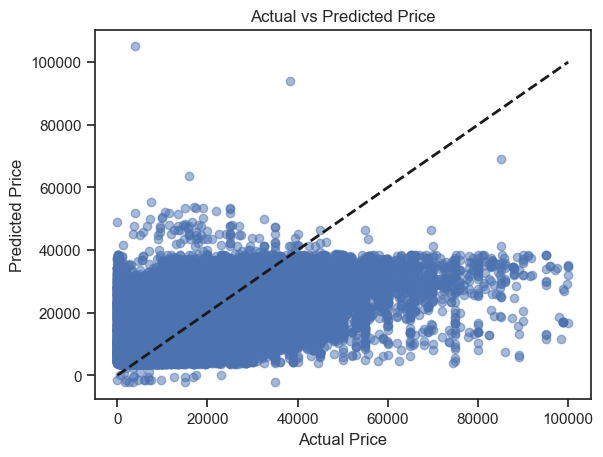

In [252]:
# Predict target
y_pred = cubic_pipe.predict(X)

plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()


The plot above from the pervious model is again better at predicting prices of autos lower priced cars. Above $25,000 or $300,000 the model quickly deteriorates.

As the analyst for the owner of the used car business, I'm still not happy with the fit of the model.

Below I test running additional degrees in attempts to get a better fitted model. Reviewing the output of the 10 degrees, we see that the third iteration is the best performing.

In [263]:
# Define features
X = data_Clean_no_dupes[['odometer', 'year']]
y = data_Clean_no_dupes['price']


model_predictions = {}
for i in range(1, 11):
    pipe = Pipeline([
        ('quad_features', PolynomialFeatures(degree=i, include_bias=False)),
        ('quad_model', LinearRegression())
    ])
    pipe.fit(X, y)
    pred = pipe.predict(X)
    model_predictions[f'degree_{i}'] = pred
    
    print(f"Degree {i}:")
    print("MSE:", mean_squared_error(y, pred))
    print()

error_df = pd.DataFrame(model_predictions).subtract(y, axis=0)


Degree 1:
MSE: 112400915.92781848

Degree 2:
MSE: 93320573.05612184

Degree 3:
MSE: 88533741.34494965

Degree 4:
MSE: 96266310.19841811

Degree 5:
MSE: 96169578.59941405

Degree 6:
MSE: 101913325.81467707

Degree 7:
MSE: 103422494.84272656

Degree 8:
MSE: 111129032.85925099

Degree 9:
MSE: 140370927.43869475

Degree 10:
MSE: 148410722.89084348



Using a degree 10 model didn't help create a better fitting model. The third degree has the lowest MSE before it climbs again.

### Second round of data clean up
To this point, I have not been happy with model outputs. As such, I have taken up transforming data features from categorical varchar to integers data types so they can be included as additional features in the coming regression models. The intent of doing this is to include additional features generating a better fitting model (more explanatory power).

Features to be transformed into integers are: 'title_status', 'condition', 'cylinders', 'transmission', 'fuel' and 'type'.
The transformation steps below identify unique data points in each feature and then remap them to numerics. Remapping was done in ascending order, lowest/fewest order to highest order. In the event a feature contained non-ordered data (such as fuel) data was ordered from dirty to clean fuel type. 

In [258]:
unique_title_status = data_Clean_no_dupes['title_status'].unique()
print(unique_title_status)


['clean' 'missing' 'parts only' 'salvage' 'lien' 'rebuilt']


In [262]:
# Define the mapping dictionary
title_status_mapping = {'missing': 0, 'parts only': 1, 'salvage': 2, 'rebuilt': 3, 'lien': 4, 'clean': 5}

# Replace the values in the 'title_status' column
data_Clean_no_dupes['title_status'] = data_Clean_no_dupes['title_status'].replace(title_status_mapping)


/var/folders/wh/n3cd2y512zb7kz6vl0n6rh180000gn/T/ipykernel_1663/2408464774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Clean_no_dupes['title_status'] = data_Clean_no_dupes['title_status'].replace(title_status_mapping)


In [268]:
condition_status = data_Clean_no_dupes['condition'].unique()
print(condition_status)

[1 2 0 3 4 5]


In [266]:
# Define the mapping dictionary
condition_mapping = {'salvage': 0, 'fair': 1, 'good': 2, 'excellent': 3, 'like new': 4, 'new': 5}

# Replace the values in the 'condition' column
data_Clean_no_dupes['condition'] = data_Clean_no_dupes['condition'].replace(condition_mapping)


/var/folders/wh/n3cd2y512zb7kz6vl0n6rh180000gn/T/ipykernel_1663/4209764664.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Clean_no_dupes['condition'] = data_Clean_no_dupes['condition'].replace(condition_mapping)


In [269]:
cylinder_status = data_Clean_no_dupes['cylinders'].unique()
print(cylinder_status)

['8 cylinders' '4 cylinders' '6 cylinders' '12 cylinders' '5 cylinders'
 'other' '10 cylinders' '3 cylinders']


In [271]:
# Define the mapping dictionary
cylinders_mapping = {'other': 0, '3 cylinders': 3, '4 cylinders': 4, '5 cylinders': 5, '6 cylinders': 6, '8 cylinders': 8, '10 cylinders': 10, '12 cylinders': 12}

# Replace the values in the 'cylinders' column
data_Clean_no_dupes['cylinders'] = data_Clean_no_dupes['cylinders'].replace(cylinders_mapping)

/var/folders/wh/n3cd2y512zb7kz6vl0n6rh180000gn/T/ipykernel_1663/2662536740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Clean_no_dupes['cylinders'] = data_Clean_no_dupes['cylinders'].replace(cylinders_mapping)


In [273]:
tranmission_status = data_Clean_no_dupes['transmission'].unique()
print(tranmission_status)

['automatic' 'manual' 'other']


In [274]:
# Define the mapping dictionary
transmission_mapping = {'other': 0, 'manual': 1, 'automatic': 2}

# Replace the values in the 'transmission' column
data_Clean_no_dupes['transmission'] = data_Clean_no_dupes['transmission'].replace(transmission_mapping)


/var/folders/wh/n3cd2y512zb7kz6vl0n6rh180000gn/T/ipykernel_1663/786883011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Clean_no_dupes['transmission'] = data_Clean_no_dupes['transmission'].replace(transmission_mapping)


In [277]:
fuel_status = data_Clean_no_dupes['fuel'].unique()
print(fuel_status)

['gas' 'diesel' 'hybrid' 'other' 'electric']


In [279]:
# Define the mapping dictionary
fuel_mapping = {'other': 0, 'diesel': 1, 'gas': 2, 'hybrid': 3, 'electric': 4}

# Replace the values in the 'fuel' column
data_Clean_no_dupes['fuel'] = data_Clean_no_dupes['fuel'].replace(fuel_mapping)


/var/folders/wh/n3cd2y512zb7kz6vl0n6rh180000gn/T/ipykernel_1663/3224945820.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Clean_no_dupes['fuel'] = data_Clean_no_dupes['fuel'].replace(fuel_mapping)


In [280]:
type_status = data_Clean_no_dupes['type'].unique()
print(type_status)

['pickup' 'SUV' 'truck' 'van' 'coupe' 'convertible' 'bus' 'wagon'
 'hatchback' 'sedan' 'other' 'mini-van' 'offroad']


In [281]:
# Define the mapping dictionary
type_mapping = {'other': 0, 'bus': 1, 'van': 2, 'mini-van': 3, 'wagon': 4, 'offroad': 5, 'truck': 6, 'pickup': 7, 'SUV': 8, 'sedan': 9, 'coupe': 10, 'hatchback': 11, 'convertible': 12}

# Replace the values in the 'type' column
data_Clean_no_dupes['type'] = data_Clean_no_dupes['type'].replace(type_mapping)

/var/folders/wh/n3cd2y512zb7kz6vl0n6rh180000gn/T/ipykernel_1663/2693430750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Clean_no_dupes['type'] = data_Clean_no_dupes['type'].replace(type_mapping)


Below is visual confirmation of the previous data transformations.

In [282]:
data_Clean_no_dupes.head()

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,cluster,manufacturer_code
0,1,6999,1973,dodge,power wagon,1,8,2,1000000.0,5,2,4wd,7,grey,co,3,0
1,2,1800,1985,chevrolet,k5 blazer,2,8,2,1000000.0,5,2,4wd,8,white,va,3,1
2,3,2000,2004,chevrolet,silverado,2,4,2,1000000.0,5,2,rwd,7,blue,tx,3,1
3,4,12000,1949,ford,f-1,1,6,2,1000000.0,5,1,rwd,7,blue,co,3,2
4,5,35000,1978,toyota,land cruiser,2,8,2,1000000.0,5,1,4wd,8,red,al,3,3


### Modeling with transformed dataset

The model below uses a polynomial degree 3 pipeline. The MSE proves this model does not perform as well as our current winning model using the binned data. The consolation is that this model includes seven more features.

In [301]:
# Define features
X = data_Clean_no_dupes[['odometer', 'year', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'type', 'manufacturer_code']]
y = data_Clean_no_dupes['price']


degree = 3
cubic_pipe = Pipeline([
    ('quad_features', PolynomialFeatures(degree=degree)),
    ('quad_model', LinearRegression())
])
cubic_pipe.fit(X, y)
coefficients = cubic_pipe.named_steps['quad_model'].coef_
intercept = cubic_pipe.named_steps['quad_model'].intercept_

cubic_mse = mean_squared_error(y, cubic_pipe.predict(X))

#print("Coefficients:", coefficients)
print("Intercept:", intercept)
print("Mean Squared Error:", cubic_mse)



Intercept: 59352199.8371026
Mean Squared Error: 103540849.35559861


The last model that I trained uses the ridge technique instead of linear regression. The MSE of this model is very similar to the binned dataset. I like this model more because it includes seven additional features. The use of these additional features will be instrumental in telling the client which features to seek out or avoid.

In [302]:
# Define features
X = data_Clean_no_dupes[['odometer', 'year', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'type', 'manufacturer_code']]
y = data_Clean_no_dupes['price']


degree = 3
cubic_pipe = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('std_scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

cubic_pipe.fit(X, y)
coefficients = cubic_pipe.named_steps['ridge'].coef_
intercept = cubic_pipe.named_steps['ridge'].intercept_
cubic_mse = mean_squared_error(y, cubic_pipe.predict(X))

#print("Coefficients:", coefficients)
print("Intercept:", intercept)
print("Mean Squared Error:", cubic_mse)


Intercept: 14688.335079128541
Mean Squared Error: 47479100.63516416


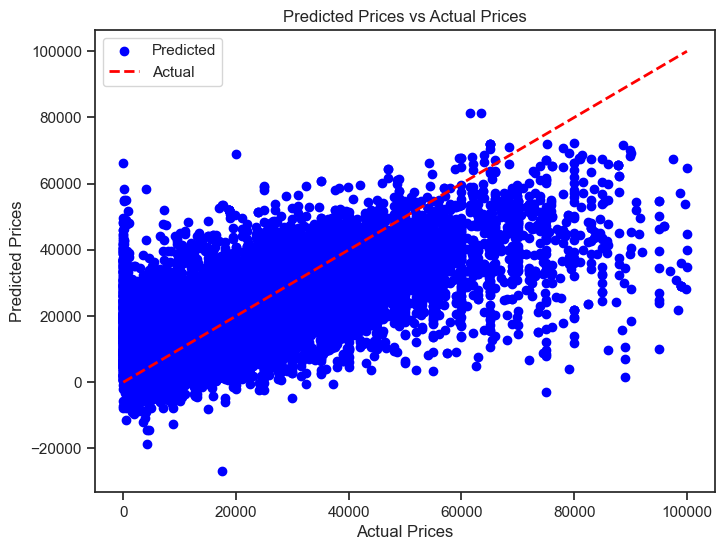

In [287]:
import matplotlib.pyplot as plt

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y, cubic_pipe.predict(X), color='blue', label='Predicted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', lw=2, label='Actual')
plt.title('Predicted Prices vs Actual Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()


The above plot shows the model again fits well for lower priced autos, but for the first time, it fits increasingly well through $40,000+.